# DEPLOY PYTORCH MODELS WITH ONNX

In [1]:
import torch
from torch.autograd import Variable
import pandas as pd
import numpy as np
from sklearn.datasets import load_boston
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')

In [2]:
boston = load_boston()

In [3]:
col_names = ['feature_' + str(i) for i in range(boston['data'].shape[1])]

In [4]:
full_set = pd.DataFrame(boston['data'], columns=col_names)

In [5]:
full_set.head()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


In [6]:
boston.keys()

dict_keys(['feature_names', 'data', 'target', 'DESCR'])

In [7]:
# add labels
full_set['y_true'] = boston['target']

In [8]:
full_set.head()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,y_true
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [9]:
# normalise features

In [10]:
scalers_dict = {}

In [11]:
for col in col_names:
    scaler = MinMaxScaler()
    full_set[col] = scaler.fit_transform(full_set[col].values.reshape(-1, 1))    
    # add to dictionary
    scalers_dict[col] = scaler

In [12]:
full_set.head()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,y_true
0,0.000000,0.18,0.067815,0.0,0.314815,0.577505,0.641607,0.269203,0.000000,0.208015,0.287234,1.000000,0.089680,24.0
1,0.000236,0.00,0.242302,0.0,0.172840,0.547998,0.782698,0.348962,0.043478,0.104962,0.553191,1.000000,0.204470,21.6
2,0.000236,0.00,0.242302,0.0,0.172840,0.694386,0.599382,0.348962,0.043478,0.104962,0.553191,0.989737,0.063466,34.7
3,0.000293,0.00,0.063050,0.0,0.150206,0.658555,0.441813,0.448545,0.086957,0.066794,0.648936,0.994276,0.033389,33.4
4,0.000705,0.00,0.063050,0.0,0.150206,0.687105,0.528321,0.448545,0.086957,0.066794,0.648936,1.000000,0.099338,36.2


In [13]:
# split full_set to training and testing sets

In [14]:
training_set = full_set.sample(n=int(len(full_set) * 0.7), random_state=42)
validating_set = full_set[~full_set.index.isin(training_set.index)].sample(n=int(len(full_set) * 0.15), random_state=42)
testing_set = full_set[(~full_set.index.isin(training_set.index)) &
                       (~full_set.index.isin(validating_set.index))].copy()

In [15]:
print('Training Set Shape:', training_set.shape)
print('Validating Set Shape:', validating_set.shape)
print('Testing Set Shape:', testing_set.shape)

Training Set Shape: (354, 14)
Validating Set Shape: (75, 14)
Testing Set Shape: (77, 14)


In [16]:
# convert to matrices for PyTorch
training_set_matrix = training_set[col_names].as_matrix()
validating_set_matrix = validating_set[col_names].as_matrix()
testing_set_matrix = testing_set[col_names].as_matrix()

Set Up PyTorch Model

For the purpose of this example model is very simple one-layer network with ReLU

In [17]:
input_1_dim = training_set_matrix.shape[1]

In [18]:
model = torch.nn.Sequential(
        torch.nn.Linear(int(input_1_dim), 1),
        torch.nn.ReLU()
)

In [19]:
# set up loss and batch sizes
criterion = torch.nn.MSELoss(size_average=True, reduce=True)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

n_epochs = 5000
batch_size = 32

# containers to store 
val_loss = []
train_loss = []

In [20]:
# convert to PyTorch Variables

In [21]:
train_label = training_set['y_true'].as_matrix()
y = Variable(torch.from_numpy(train_label).float(), requires_grad=False)
x = Variable(torch.from_numpy(training_set_matrix).float())

val_label = validating_set['y_true'].as_matrix()
y_val = Variable(torch.from_numpy(val_label).float(), requires_grad=False)
x_val = Variable(torch.from_numpy(validating_set_matrix).float())

In [22]:
x_test = Variable(torch.from_numpy(testing_set_matrix).float())

Train the Model

In [23]:
# for each epoch
for t in range(n_epochs):
    # Forward pass: Compute predicted y by passing x to the model
    
    # create a permutation
    permutation = torch.randperm(x.size()[0])
    permutation_val = torch.randperm(x_val.size()[0])
    
    epoch_loss = 0
    epoch_loss_val = 0
    
    # loop over each batch
    for b in range(0, x.size()[0], batch_size):
        
        optimizer.zero_grad()
        
        # select indices
        indices = permutation[b: b+batch_size]
        
        # select batches
        batch_x, batch_y = x[indices], y[indices]
        # batch prediction    
        y_pred_batch = model(batch_x)

        # Compute and print loss
        loss = criterion(y_pred_batch, batch_y)
        
        # Compute train loss
        y_pred_val = model(x_val)
        loss_val = criterion(y_pred_val, y_val)
        
        # Zero gradients, perform a backward pass, and update the weights.
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.data[0]**(1/2)
        epoch_loss_val += loss_val.data[0]**(1/2)

    train_loss.append(epoch_loss)
    val_loss.append(epoch_loss_val)

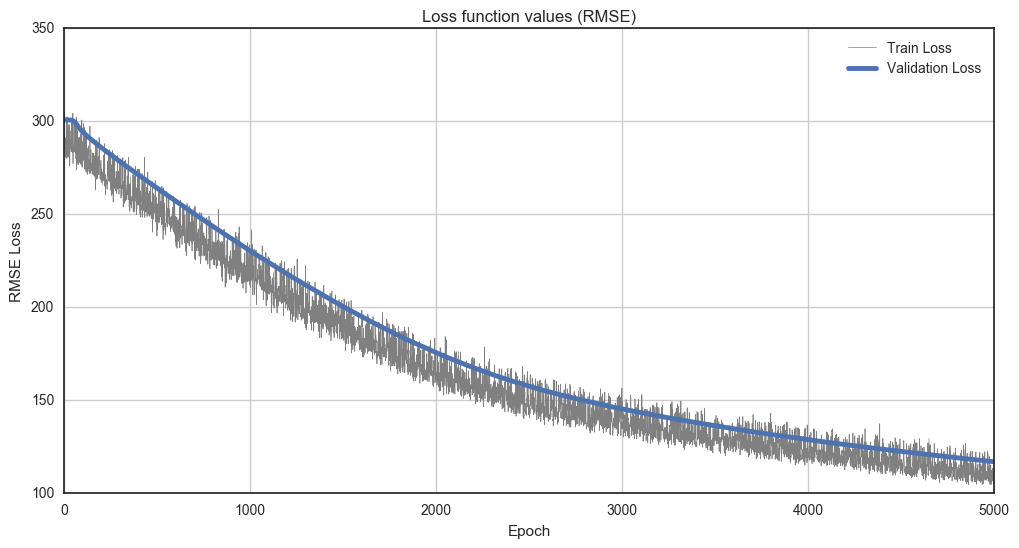

In [24]:
plt.figure(figsize=(12, 6))
plt.title('Loss function values (RMSE)')
plt.plot(train_loss, label='Train Loss', linewidth=0.5, color='grey')
plt.plot(val_loss, label='Validation Loss', linewidth=3.5)
plt.ylabel('RMSE Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.grid()
plt.show()

As we can see from the figure, RMSE keeps decreasing up to a point where model start overfitting. At this point we stop training and prepare the model for exporting. Before doing that we check the RMSE from holdout (testing) set

In [25]:
model.eval()

Sequential(
  (0): Linear(in_features=13, out_features=1, bias=True)
  (1): ReLU()
)

In [27]:
# Export the Model
# create dummy input and make sure it is compatible with the model
dummy_input = Variable(torch.randn(x_val[1:2, :].size()), requires_grad=True) * 0.5

In [29]:
test_pred = model(dummy_input)

In [30]:
torch_out = torch.onnx._export(model, dummy_input, 'test_NN.onnx', verbose=True, export_params=True)

graph(%1 : Float(1, 13)
      %2 : Float(1, 13)
      %3 : Float(1)) {
  %6 : Float(1, 1) = Gemm[alpha=1, beta=1, broadcast=1, transB=1](%1, %2, %3), uses = [%7.i0], scope: Sequential/Linear[0];
  %7 : Float(1, 1) = Relu(%6), uses = [%0.i0], scope: Sequential/ReLU[1];
  return (%7);
}



In [ ]:
# To export the model, use this command (in the terminal)
!mxnet-model-export --model-path . --model-name boston_nn --service-file-path boston_nn_service.py

In [2]:
# Finally, to serve the model do
!mxnet-model-server --models boston_nn=boston_nn.model
# (after this you should see server starting and logs appearing)

In [3]:
# lastly, you CURL the server to get predictions (from the terminal)
!curl -X POST http://127.0.0.1:8080/boston_nn/predict -F "input_0=[1.0,2.8, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]”
# and the server should respond with nice JSON: {"prediction": "[ 259.667]"}